## This section shows how to use both the text from four json folders and meta data to do a query to search for the information we need

In [ ]:
import os
import json
from pprint import pprint
from copy import deepcopy

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from subprocess import check_output

###  Part 1: **Load all json and convert to dataframe**
This part can be run in Kaggle. However when doing the tokenizer, the kernel stopped due to memory limit reached.
So it's shown below to demonstrate how to do it. But some parts will be commented out so they are not excuted for the submission

In [ ]:
# this part use functions from kernel CORD-19-EDA,parse JSON and generate clean csv
# https://www.kaggle.com/xhlulu/cord-19-eda-parse-json-and-generate-clean-csv
def format_name(author):
    middle_name = " ".join(author['middle'])
    
    if author['middle']:
        return " ".join([author['first'], middle_name, author['last']])
    else:
        return " ".join([author['first'], author['last']])

def format_affiliation(affiliation):
    text = []
    location = affiliation.get('location')
    if location:
        text.extend(list(affiliation['location'].values()))
    
    institution = affiliation.get('institution')
    if institution:
        text = [institution] + text
    return ", ".join(text)

def format_authors(authors, with_affiliation=False):
    name_ls = []
    
    for author in authors:
        name = format_name(author)
        if with_affiliation:
            affiliation = format_affiliation(author['affiliation'])
            if affiliation:
                name_ls.append(f"{name} ({affiliation})")
            else:
                name_ls.append(name)
        else:
            name_ls.append(name)
    
    return ", ".join(name_ls)

def format_body(body_text):
    texts = [(di['section'], di['text']) for di in body_text]
    texts_di = {di['section']: "" for di in body_text}
    
    for section, text in texts:
        texts_di[section] += text

    body = ""

    for section, text in texts_di.items():
        body += section
        body += "\n\n"
        body += text
        body += "\n\n"
    
    return body

def format_bib(bibs):
    if type(bibs) == dict:
        bibs = list(bibs.values())
    bibs = deepcopy(bibs)
    formatted = []
    
    for bib in bibs:
        bib['authors'] = format_authors(
            bib['authors'], 
            with_affiliation=False
        )
        formatted_ls = [str(bib[k]) for k in ['title', 'authors', 'venue', 'year']]
        formatted.append(", ".join(formatted_ls))

    return "; ".join(formatted)

def load_files(dirname):
    filenames = os.listdir(dirname)
    raw_files = []

    for filename in tqdm(filenames):
        filename = dirname + filename
        file = json.load(open(filename, 'rb'))
        raw_files.append(file)
    
    return raw_files

def generate_clean_df(all_files):
    cleaned_files = []
    
    for file in tqdm(all_files):
        features = [
            file['paper_id'],
            file['metadata']['title'],
            format_authors(file['metadata']['authors']),
            format_authors(file['metadata']['authors'], 
                           with_affiliation=True),
            format_body(file['abstract']),
            format_body(file['body_text']),
            format_bib(file['bib_entries']),
            file['metadata']['authors'],
            file['bib_entries']
        ]

        cleaned_files.append(features)

    col_names = ['paper_id', 'title', 'authors',
                 'affiliations', 'abstract', 'text', 
                 'bibliography','raw_authors','raw_bibliography']

    clean_df = pd.DataFrame(cleaned_files, columns=col_names)
    clean_df.head()
    
    return clean_df

In [ ]:
biorxiv_dir = '/kaggle/input/CORD-19-research-challenge/biorxiv_medrxiv/biorxiv_medrxiv/pdf_json/'
filenames = os.listdir(biorxiv_dir)
print("Number of articles retrieved from biorxiv:", len(filenames))

In [ ]:
all_files = []

for filename in filenames:
    filename = biorxiv_dir + filename
    file = json.load(open(filename, 'rb'))
    all_files.append(file)
file = all_files[0]
print("Dictionary keys:", file.keys())

In [ ]:
cleaned_files = []

for file in tqdm(all_files):
    features = [
        file['paper_id'],
        file['metadata']['title'],
        format_authors(file['metadata']['authors']),
        format_authors(file['metadata']['authors'], 
                       with_affiliation=True),
        format_body(file['abstract']),
        format_body(file['body_text']),
        format_bib(file['bib_entries']),
        file['metadata']['authors'],
        file['bib_entries']
    ]
    
    cleaned_files.append(features)
len(cleaned_files)

In [ ]:
col_names = [
    'paper_id', 
    'title', 
    'authors',
    'affiliations', 
    'abstract', 
    'text', 
    'bibliography',
    'raw_authors',
    'raw_bibliography'
]

clean_df = pd.DataFrame(cleaned_files, columns=col_names)
clean_df.head(5)

In [ ]:
#clean_df.to_csv('biorxiv_clean.csv', index=False)
pmc_dir = '/kaggle/input/CORD-19-research-challenge/custom_license/custom_license/pdf_json/'
pmc_files = load_files(pmc_dir)
pmc_df = generate_clean_df(pmc_files)
#pmc_df.to_csv('clean_pmc.csv', index=False)
#pmc_df.head()
comm_dir = '/kaggle/input/CORD-19-research-challenge/comm_use_subset/comm_use_subset/pdf_json/'
comm_files = load_files(comm_dir)
comm_df = generate_clean_df(comm_files)
#comm_df.to_csv('clean_comm_use.csv', index=False)
#comm_df.head()
noncomm_dir = '/kaggle/input/CORD-19-research-challenge/noncomm_use_subset/noncomm_use_subset/pdf_json/'
noncomm_files = load_files(noncomm_dir)
noncomm_df = generate_clean_df(noncomm_files)
#noncomm_df.to_csv('clean_noncomm_use.csv', index=False)
#noncomm_df.head()


In [ ]:
#check the number of json files from each directory
print(len(clean_df))
print(len(pmc_df))
print(len(comm_df))
print(len(noncomm_df))

In [ ]:
bigdata1 = pd.concat([clean_df, pmc_df], ignore_index=True, sort =False)
bigdata2 = pd.concat([comm_df, noncomm_df], ignore_index=True, sort =False)
final_df = pd.concat([bigdata1, bigdata2], ignore_index=True, sort =False)
print(len(final_df))
#final_df.to_csv('alljson.csv', index=False)
del clean_df,pmc_df,comm_df,noncomm_df,bigdata1,bigdata2

In [ ]:
#final_df.columns

In [ ]:
#final_df['paper_id'][:5]

### Part 2: **Loading the metadata**

In [ ]:
meta_df = pd.read_csv('/kaggle/input/CORD-19-research-challenge/metadata.csv') # 
 
nRow, nCol = meta_df.shape
print(f'There are {nRow} rows and {nCol} columns')

In [ ]:
meta_df.head(5)

In [ ]:
meta_df.columns

In [ ]:
meta_df['sha'].isna().sum()  # null id number

In [ ]:
meta_df1=meta_df[meta_df['sha'].notnull()]
print(len(meta_df1))

### Part 3: Merge two dataframes, metadata and all json text

In [ ]:
"""
# If we want to merge the two data frames, meta_df1 is from meta data, and final_df is from json and has text info
# but running on Kaggle encountered the memory issue, so this part is only if your machine has enough memory and 
# finding out how many paper id from json overlaps with metadata sha, so we can merge them together
print(len(list(set(meta_df1['sha'])&set(final_df['paper_id']))))
#merge two dataframes
pd_merge_all= pd.merge(meta_df1, final_df, how='inner',left_on='sha', right_on='paper_id')
print(len(pd_merge_all))
# remove some duplicate columns
pd_merge_all=pd_merge_all[['cord_uid', 'sha', 'source_x', 'title_x', 'doi', 'pmcid', 'pubmed_id',
       'license', 'abstract_x', 'publish_time', 'authors_x', 'journal',
       'Microsoft Academic Paper ID', 'WHO #Covidence', 'has_pdf_parse',
       'has_pmc_xml_parse', 'full_text_file', 'url', 'affiliations', 'text', 'bibliography',
       'raw_authors', 'raw_bibliography']]
pd_merge_all=pd_merge_all.dropna(subset=['sha', 'text'])  # drop if any of these two columns have nan

"""

In [ ]:
# since we didn't use the above step, so use meta data only
pd_merge_all=meta_df1

In [ ]:
pd_merge_all.head()

###  Part 4   NLP processing 

In [ ]:
import re
import nltk
import string

In [ ]:
# remove nan titles
print(len(pd_merge_all))
pd_merge_all=pd_merge_all[pd_merge_all['title']!='nan']
# remove nan abstracts
print(len(pd_merge_all))
pd_merge_all=pd_merge_all[pd_merge_all['abstract']!='nan']
print(len(pd_merge_all))

  #### Normalization of text
The following was only done to metadata abstract text, it can be easily done to alljson dataframe text column, but due to memory limit, only show the process to abstract 

In [ ]:
# data cleaning
def clean_dfonecol(new_df,col):
    new_df=new_df.replace(np.nan,'',regex = True)
    new_df = new_df[pd.notnull(new_df[col])] 
    #print(len(new_df))
    # lower case
    new_df[col] = new_df[col].apply(lambda x: x.lower()) 
    #punctuation
    new_df[col] = new_df[col].apply(lambda x: x.translate(str.maketrans('','',string.punctuation)))
    return new_df

# below is the data with full text info, for now, dropped
#pd_merge_all=clean_dfonecol(pd_merge_all,'title_x')
#print(len(pd_merge_all))
#pd_merge_all=clean_dfonecol(pd_merge_all,'abstract_x')
#print(len(pd_merge_all))
#pd_merge_all=clean_dfonecol(pd_merge_all,'text')    # too much text to process
#print(len(pd_merge_all))

In [ ]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stop = stopwords.words('english')
    
def remv_stopwords(new_df,col):
# remove stopwords
    
    new_df[col]= new_df[col].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    new_df[col]= new_df[col].str.findall('\w{2,}').str.join(' ')
    return new_df

#pd_merge_all=remv_stopwords(pd_merge_all,'abstract_x')
#pd_merge_all=remv_stopwords(pd_merge_all,'text') # takes too much memory, so not runnning it

##### Since text column will take a lot of memory, will only perform on abstract for now

In [ ]:
# only process abstract from meta_df1
#print(len(meta_df1))
meta_df1=clean_dfonecol(pd_merge_all,'abstract')
print(len(meta_df1))

In [ ]:
#print(len(meta_df1))
meta_df1=remv_stopwords(meta_df1,'abstract')
print(len(meta_df1))

In [ ]:
meta_df1.reset_index(inplace=True)

### Text processing

In [ ]:
# put all abstract in one list, sentence by sentence
text1=[]
for i in range(len(meta_df1)):
    text1.append(meta_df1['abstract'].loc[i])

# put all, by words
text2=[]  
for i in range(len(meta_df1)):
    text2.append(meta_df1['abstract'].loc[i].split())

In [ ]:
import gensim
from gensim import corpora
from pprint import pprint
# Create dictionary by using all the words
dictionary = corpora.Dictionary(text2)

In [ ]:
# Get information about the dictionary
print(dictionary)

In [ ]:
#print(dictionary.token2id[) 

In [ ]:
# Create the Corpus
mydict = corpora.Dictionary()
mycorpus = [mydict.doc2bow(doc, allow_update=True) for doc in text2]
#pprint(mycorpus[:10])   # this will show the token and its frequency in the text 

In [ ]:
# create word count
word_counts = [[(mydict[id], count) for id, count in line] for line in mycorpus]
#pprint(word_counts[:100]) 

In [ ]:
#import gensim.downloader as api
#dataset = api.load("text8")

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

In [ ]:
show_wordcloud(text2)

In [ ]:
# Use gensim summarization 
from gensim.summarization import summarize, keywords
#from pprint import pprint

In [ ]:
# Important keywords from the paragraph
print(text1[100])  # one abstract example
# the keyword from this paragraph
print(keywords(text1[100]))  

In [ ]:
# Summarize the paragraph
# need the comma to distinguish the sentences, just one example below
text1examp="outbreak pneumonia originating wuhan china generated 24500 confirmed cases including 492 deaths. february \
2020 virus 2019ncov spread elsewhere china, 24 countries including south korea, thailand, japan, usa. fortunately limited \
humantohuman transmission outside china. assess risk sustained transmission whenever coronavirus arrives countries. data \
describing times symptom onset hospitalisation. 47 patients infected. early current outbreak used generate estimate \
probability. imported case followed sustained humantohuman transmission assumptions. imported case representative  \
patients china. 2019ncov similarly transmissible sars. coronavirus probability imported case followed sustained  \
humantohuman transmission. 041 credible interval. however mean time symptom onset hospitalisation halved.  \
intense surveillance probability imported case leads sustained transmission. 0012 credible interval. 0099 emphasises. \
importance current surveillance efforts. countries around world ensure ongoing outbreak become global pandemic."
pprint(summarize(text1examp, word_count=20)) # this will be good for full text summarize

#### It shows that abstracts  has 112323 unique tokens from 29500 papers, this number will change with added papers

### Part 5:  **Search Use BM25**

The bm25 rank feature implements the Okapi BM25 ranking function used to estimate the relevance of a text document given a search query. It is a pure text ranking feature which operates over an indexed string field. The feature is very cheap to compute, about 3-4 times faster than nativeRank, while still providing a good rank score quality wise. It is a good candidate to use in a first phase ranking function when ranking text documents.

The bm25 feature calculates a score for how good a query with terms q1,...,qn
 matches an indexed string field t in a document D. The score is calculated as follows:
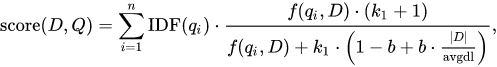
where f(qi,D) is qi's term frequency in the document D, |D| is the length of the document D in words, and avgdl is the average document length in the text collection from which documents are drawn. k1 and b are free parameters, usually chosen, in absence of an advanced optimization. IDF(qi) is the IDF (inverse document frequency) weight of the query term qi. It is usually computed as:

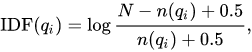
where N is the total number of documents in the collection, and n(qi) is the number of documents containing qi.

In [ ]:
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import preprocess_documents, preprocess_string
# tockenize abstract
meta_df_tokens = meta_df1.abstract.fillna('').apply(preprocess_string) 

In [ ]:
!pip install rank_bm25

In [ ]:
from rank_bm25 import BM25Okapi

# tockenize abstract
#pd_merge_abstract_tokens = pd_merge_all.abstract_x.fillna('').apply(preprocess_string)  # tokenize each abstract to word
# tockenize the text, this is too memory consuming to be run on kaggle machine
#pd_merge_text_tokens = pd_merge_all.text.fillna('').apply(preprocess_string)  # tokenize each textto word

In [ ]:
meta_df_tokens[:100]

In [ ]:
from nltk.corpus import wordnet
nltk.download('wordnet')
def find_syn_ant(word):
    synonyms = []
    antonyms = []

    for syn in wordnet.synsets(word):
        for l in syn.lemmas():
            synonyms.append(l.name())
            if l.antonyms():
                antonyms.append(l.antonyms()[0].name())

    #print(set(synonyms))
    #print(set(antonyms))
    return set(synonyms)

print(find_syn_ant("smoking"))

Create a BM25Okapi index from the tokens. Implement a search function that returns the top 10 results from the search. Note that in search wer are asking the index to return the dataframe indexes of the tokens most similar to the search string.

In [ ]:
bm25_index = BM25Okapi(meta_df_tokens.tolist())

def search(search_string, num_results=10):  # can change the num_results to top 50 or more
    search_tokens = preprocess_string(search_string)
    scores = bm25_index.get_scores(search_tokens)
    top_indexes = np.argsort(scores)[::-1][:num_results]
    return top_indexes

In [ ]:
# example: now show the abstract of the top index
meta_df1.loc[search('novel coronavirus treatment')][['abstract', 'publish_time']]

### Below are the ones we need to check related to different risk factors:

- Data on potential risks factors
        - Smoking, pre-existing pulmonary disease
        - Co-infections (determine whether co-existing respiratory/viral infections make the virus more transmissible or virulent) and other co-morbidities
        - Neonates and pregnant women
        - Socio-economic and behavioral factors to understand the economic impact of the virus and whether there were differences.
- Transmission dynamics of the virus, including the basic reproductive number, incubation period, serial interval, modes of transmission and environmental factors
- Severity of disease, including risk of fatality among symptomatic hospitalized patients, and high-risk patient groups
- Susceptibility of populations
- Public health mitigation measures that could be effective for control

In [ ]:
# Now break the above questions to the following search strings
string1='smoking, pre-existing pulmonary disease'
string2= 'Co-infections (determine whether co-existing respiratory/viral infections make the virus more transmissible or virulent) and other co-morbidities'
string3= 'Neonates and pregnant women'
string4=  'Socio-economic and behavioral factors to understand the economic impact of the virus and whether there were differences'
string5= 'Transmission dynamics of the virus, including the basic reproductive number, incubation period, serial interval, modes of transmission and environmental factors'
string6=  'Severity of disease, including risk of fatality among symptomatic hospitalized patients, and high-risk patient groups'
string7=  'Susceptibility of populations'
string8= 'Public health mitigation measures that could be effective for control'

In [ ]:
meta_df1.loc[search(string1)][['abstract', 'publish_time']]

In [ ]:
meta_df1.loc[search(string2)][['abstract', 'publish_time']]

In [ ]:
meta_df1.loc[search(string3)][['abstract', 'publish_time']]

In [ ]:
meta_df1.loc[search(string4)][['abstract', 'publish_time']]

In [ ]:
meta_df1.loc[search(string5)][['abstract', 'publish_time']]

In [ ]:
meta_df1.loc[search(string6)][['abstract', 'publish_time']]

In [ ]:
meta_df1.loc[search(string7)][['abstract', 'publish_time']]

In [ ]:
meta_df1.loc[search(string8)][['abstract', 'publish_time']]

#### The above search is fast, but the search is only within the abstracts from meta data. If we have more memory, we can use the combined abstract and text data and search from text directly. It may significantly improve the query relevance score